In [ ]:
!pip install tensorflow keras opencv-python-headless

In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is NOT available.")


GPU is available.


In [ ]:
import zipfile
import os

# Unzip the file
zip_file = 'training.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

os.listdir('/content/dataset')


['train_img', 'train_lab']

In [ ]:
!ls /content/dataset

train_img  train_lab


In [ ]:
!ls /content/dataset/train_img
!ls /content/dataset/train_lab

11111.jpg    11141-2.jpg  11170-1.jpg  11190-7.jpg	7Q3A9064-10.jpg  IMG25-2.jpg
11112.jpg    11141-3.jpg  11170-2.jpg  11190.jpg	7Q3A9064-11.jpg  IMG25-3.jpg
11113.jpg    11141-4.jpg  11170.jpg    11192-1.jpg	7Q3A9064-12.jpg  IMG25-4.jpg
11114.jpg    11141.jpg	  11175-1.jpg  11192-2.jpg	7Q3A9064-13.jpg  IMG25-5.jpg
11115.jpg    11142.jpg	  11175-2.jpg  11192.jpg	7Q3A9064-14.jpg  IMG25-6.jpg
11116-1.jpg  11143.jpg	  11175-3.jpg  11193-1.jpg	7Q3A9064-15.jpg  IMG25-7.jpg
11116-2.jpg  11144.jpg	  11175.jpg    11193-2.jpg	7Q3A9064-16.jpg  IMG25-8.jpg
11116-3.jpg  11148.jpg	  11176.jpg    11193-3.jpg	7Q3A9064-17.jpg  IMG25-9.jpg
11116-4.jpg  11149.jpg	  11177.jpg    11193.jpg	7Q3A9064-18.jpg  IMG27-10.jpg
11116.jpg    11150.jpg	  11178-1.jpg  11196.jpg	7Q3A9064-19.jpg  IMG27-11.jpg
11117.jpg    11151-1.jpg  11178-2.jpg  11197-1.jpg	7Q3A9064-1.jpg	 IMG27-12.jpg
11118.jpg    11151-2.jpg  11178-3.jpg  11197-2.jpg	7Q3A9064-20.jpg  IMG27-13.jpg
11119.jpg    11151-3.jpg  11178-4.jpg  11197-3.jpg	7

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import os


In [ ]:
import os
import glob
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=8, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        print(f"Number of images found: {len(self.image_paths)}")
        print(f"Number of masks found: {len(self.mask_paths)}")
        if len(self.image_paths) == 0 or len(self.mask_paths) == 0:
            print("Error: No images or masks found. Please check the directory paths.")

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_images = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        masks = []
        for img_path, mask_path in zip(batch_images, batch_masks):
            img = cv2.resize(cv2.imread(img_path), self.image_size)
            mask = cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), self.image_size)

            if img is None or mask is None:
                print(f"Error loading file: {img_path} or {mask_path}")

            img = img / 255.0
            mask = mask / 255.0

            images.append(img)
            masks.append(mask[..., np.newaxis])

        return np.array(images), np.array(masks)

    def get_all_data(self):
        images = []
        masks = []
        for img_path, mask_path in zip(self.image_paths, self.mask_paths):
            img = cv2.resize(cv2.imread(img_path), self.image_size)
            mask = cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), self.image_size)

            if img is None or mask is None:
                print(f"Error loading file: {img_path} or {mask_path}")

            img = img / 255.0
            mask = mask / 255.0

            images.append(img)
            masks.append(mask[..., np.newaxis])

        return np.array(images), np.array(masks)


# Verify data shapes
image_dir = '/content/dataset/train_img'
mask_dir = '/content/dataset/train_lab'
train_gen = DataGenerator(image_dir, mask_dir)

images, masks = train_gen[0]
print(f'Images shape: {images.shape}, Masks shape: {masks.shape}')


Number of images found: 300
Number of masks found: 300
Images shape: (8, 256, 256, 3), Masks shape: (8, 256, 256, 1)


In [ ]:
def unet_model(input_size=(256, 256, 3)):
    inputs = tf.keras.Input(input_size)

    # Downsampling
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Upsampling
    up1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat1 = tf.keras.layers.concatenate([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = tf.keras.layers.concatenate([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)


    # Output layer (binary mask)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = tf.keras.Model(inputs, outputs)

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        131,200 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 64)   │         32,832 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 128)  │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │         73,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/GPU:0'):
     history = model.fit(train_gen, epochs=50)

Streaming output truncated to the last 5000 lines.
Loading image: /content/dataset/train_img/11139.jpg
Loading mask: /content/dataset/train_lab/11139.png
Loading image: /content/dataset/train_img/11140-1.jpg
Loading mask: /content/dataset/train_lab/11140-1.png
Loading image: /content/dataset/train_img/11140-6.jpg
Loading mask: /content/dataset/train_lab/11140-6.png
14/37 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.9901 - loss: 0.0101Loading image: /content/dataset/train_img/11151.jpg
Loading mask: /content/dataset/train_lab/11151.png
Loading image: /content/dataset/train_img/11152.jpg
Loading mask: /content/dataset/train_lab/11152.png
Loading image: /content/dataset/train_img/11153.jpg
Loading mask: /content/dataset/train_lab/11153.png
Loading image: /content/dataset/train_img/11154.jpg
Loading mask: /content/dataset/train_lab/11154.png
Loading image: /content/dataset/train_img/11155-1.jpg
Loading mask: /content/dataset/train_lab/11155-1.png
Loading image: /content/dataset/train_i

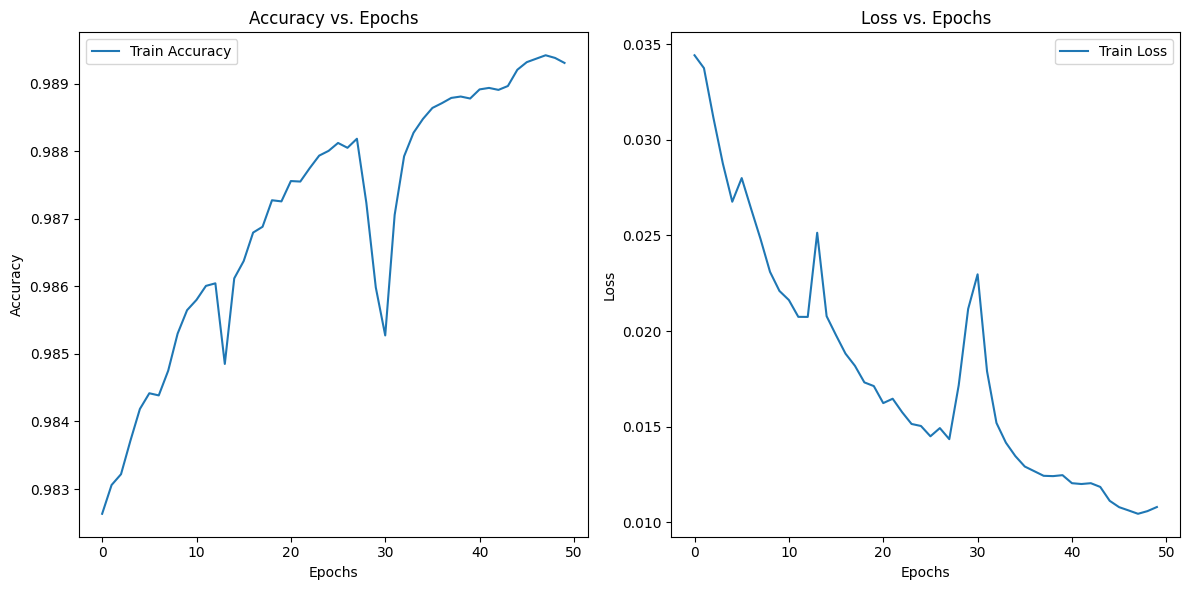

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy vs. epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history)


Loading image: /content/dataset/train_img/11111.jpg
Loading mask: /content/dataset/train_lab/11111.png
Loading image: /content/dataset/train_img/11112.jpg
Loading mask: /content/dataset/train_lab/11112.png
Loading image: /content/dataset/train_img/11113.jpg
Loading mask: /content/dataset/train_lab/11113.png
Loading image: /content/dataset/train_img/11114.jpg
Loading mask: /content/dataset/train_lab/11114.png
Loading image: /content/dataset/train_img/11115.jpg
Loading mask: /content/dataset/train_lab/11115.png
Loading image: /content/dataset/train_img/11116-1.jpg
Loading mask: /content/dataset/train_lab/11116-1.png
Loading image: /content/dataset/train_img/11116-2.jpg
Loading mask: /content/dataset/train_lab/11116-2.png
Loading image: /content/dataset/train_img/11116-3.jpg
Loading mask: /content/dataset/train_lab/11116-3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


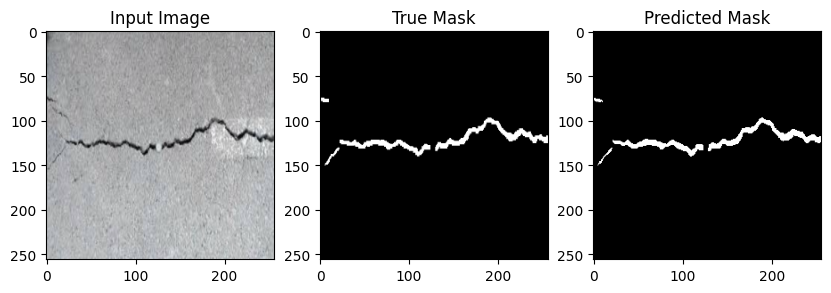

Loading image: /content/dataset/train_img/11116-4.jpg
Loading mask: /content/dataset/train_lab/11116-4.png
Loading image: /content/dataset/train_img/11116.jpg
Loading mask: /content/dataset/train_lab/11116.png
Loading image: /content/dataset/train_img/11117.jpg
Loading mask: /content/dataset/train_lab/11117.png
Loading image: /content/dataset/train_img/11118.jpg
Loading mask: /content/dataset/train_lab/11118.png
Loading image: /content/dataset/train_img/11119.jpg
Loading mask: /content/dataset/train_lab/11119.png
Loading image: /content/dataset/train_img/11120.jpg
Loading mask: /content/dataset/train_lab/11120.png
Loading image: /content/dataset/train_img/11121.jpg
Loading mask: /content/dataset/train_lab/11121.png
Loading image: /content/dataset/train_img/11122-1.jpg
Loading mask: /content/dataset/train_lab/11122-1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


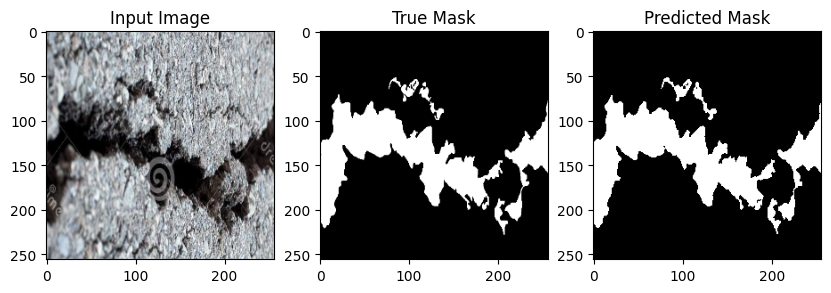

Loading image: /content/dataset/train_img/11122-2.jpg
Loading mask: /content/dataset/train_lab/11122-2.png
Loading image: /content/dataset/train_img/11122-3.jpg
Loading mask: /content/dataset/train_lab/11122-3.png
Loading image: /content/dataset/train_img/11122-4.jpg
Loading mask: /content/dataset/train_lab/11122-4.png
Loading image: /content/dataset/train_img/11122-5.jpg
Loading mask: /content/dataset/train_lab/11122-5.png
Loading image: /content/dataset/train_img/11122.jpg
Loading mask: /content/dataset/train_lab/11122.png
Loading image: /content/dataset/train_img/11123-1.jpg
Loading mask: /content/dataset/train_lab/11123-1.png
Loading image: /content/dataset/train_img/11123-2.jpg
Loading mask: /content/dataset/train_lab/11123-2.png
Loading image: /content/dataset/train_img/11123-3.jpg
Loading mask: /content/dataset/train_lab/11123-3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


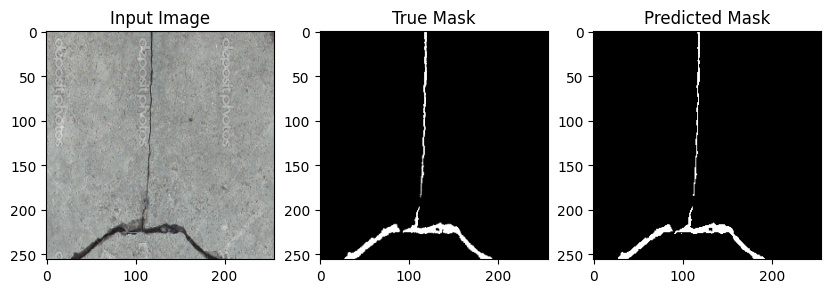

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_gen, num_images=3):
    for i in range(num_images):
        img, mask = data_gen[i]
        pred_mask = model.predict(np.expand_dims(img[0], axis=0))[0]
        pred_mask = np.squeeze(pred_mask > 0.5)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img[0])
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(mask[0]), cmap='gray')
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")

        plt.show()

plot_predictions(model, train_gen)


In [ ]:
import zipfile

# Upload and extract the zip file
zip_path = '/content/test_data.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test_data')

test_image_dir = '/content/test_data/test_img'
test_mask_dir = '/content/test_data/test_lab'

# Create test data generator
test_gen = DataGenerator(test_image_dir, test_mask_dir, batch_size=1)

# Get all test images and masks
test_images, test_masks = test_gen.get_all_data()

# Predict on all test images
test_predictions = model.predict(test_images)



Number of images found: 237
Number of masks found: 237
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


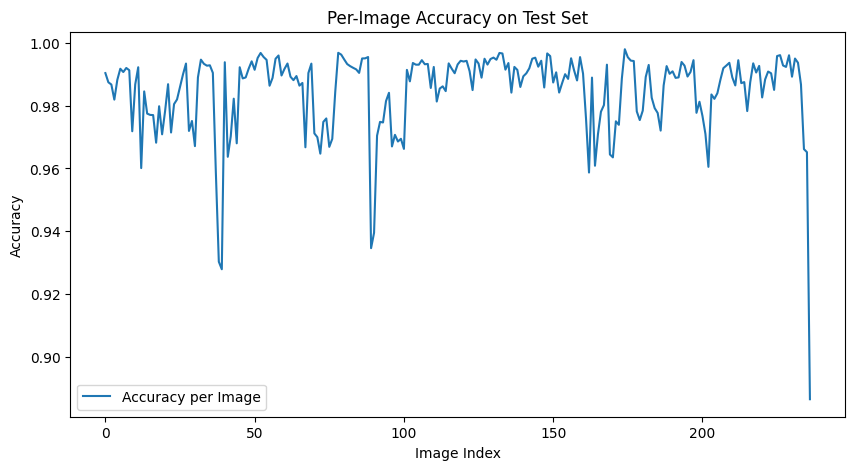

In [ ]:
# Calculate accuracy per image (assuming binary classification)
import numpy as np

def calculate_accuracy_per_image(predictions, true_masks):
    accuracies = []
    for i in range(len(predictions)):
        pred_mask = (predictions[i] > 0.5).astype(np.uint8)  # Thresholding at 0.5
        true_mask = true_masks[i].astype(np.uint8)
        accuracy = np.mean(pred_mask == true_mask)
        accuracies.append(accuracy)
    return accuracies

# Get accuracies for each image
test_accuracies = calculate_accuracy_per_image(test_predictions, test_masks)

# Plot per-image accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_accuracies)), test_accuracies, label='Accuracy per Image')
plt.xlabel('Image Index')
plt.ylabel('Accuracy')
plt.title('Per-Image Accuracy on Test Set')
plt.legend()
plt.show()


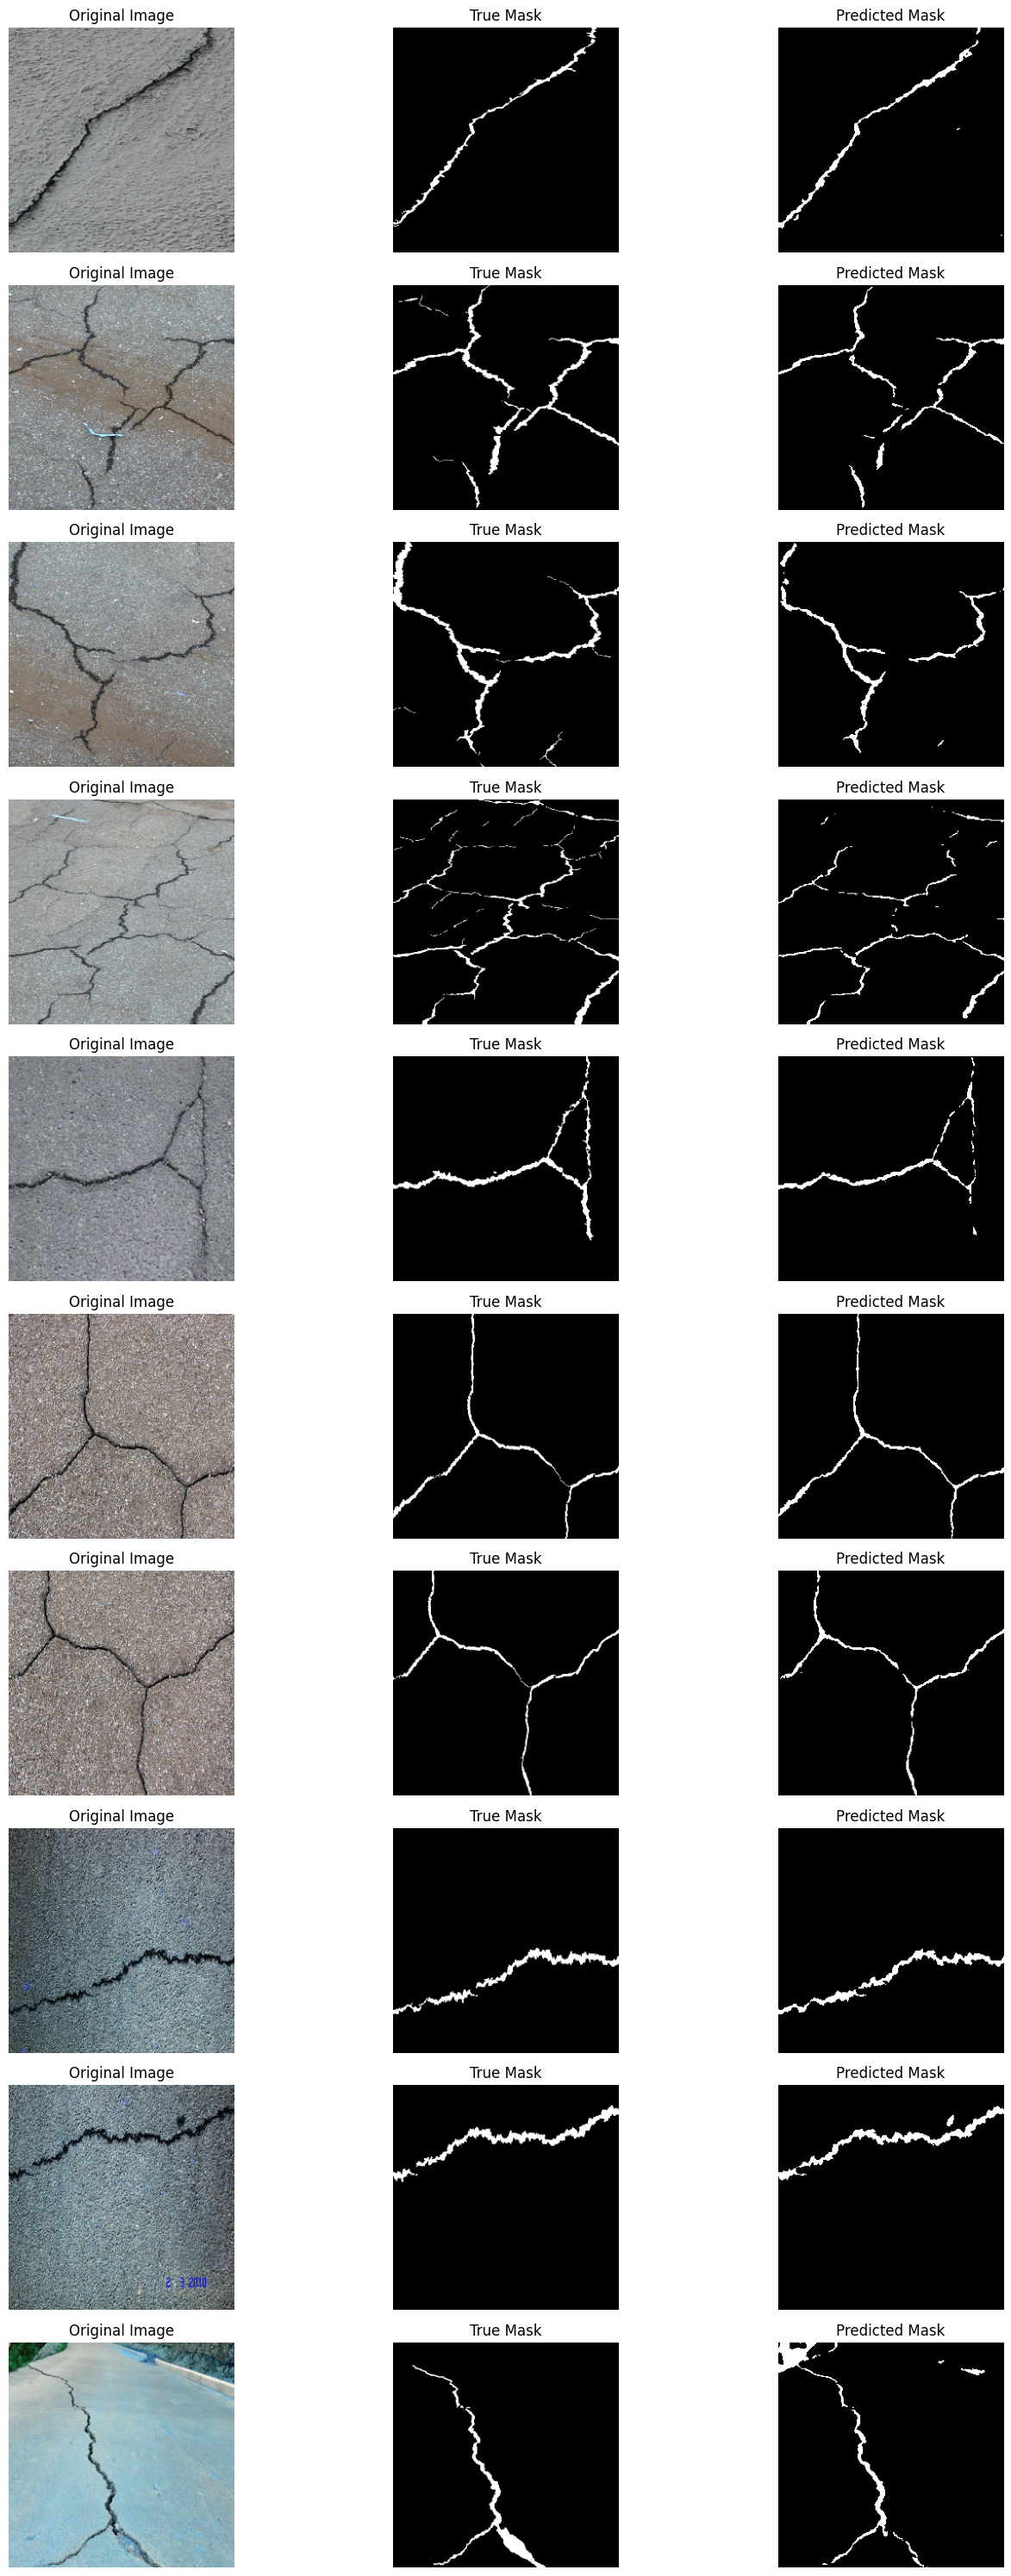

In [ ]:
def plot_sample_images(images, true_masks, predictions, n_samples=5):
    plt.figure(figsize=(15, n_samples * 3))

    for i in range(n_samples):
        # Original Image
        plt.subplot(n_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True Mask
        plt.subplot(n_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(n_samples, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze() > 0.5, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot a few sample images with true vs predicted masks
plot_sample_images(test_images, test_masks, test_predictions, n_samples=10)


In [42]:
import tensorflow as tf

model.save('MaskRCNN.h5')


In [43]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('MaskRCNN.h5')

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpuxp6qpq1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  132230738022944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738033152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738055536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738059232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738060640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738062928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738057648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738064512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738063456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230738066272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13223

In [44]:
from google.colab import files

files.download('model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>